# Recursive multi-step forecasting for categorical time series

Recursive multi-step forecasting is a technique used to predict future values in a time series by using previous predictions as inputs for subsequent forecasts. 

In the context of categorical time series, where the values belong to discrete categories rather than continuous values, the model is trained to predict the probability distribution over the possible categories for each future time step. The most likely category for the current time step is then used as input for predicting the next time step, and this process continues recursively.

Although the process is conceptually very similar to that used for continuous time series (https://skforecast.org/0.18.0/introduction-forecasting/introduction-forecasting), many challenges arise due the need to encode and decode categorical variables, as well as allowing the underlying machine learning model to handle categorical data effectively.

!TODO: add gift showing the recursive process for categorical time series

**Skforecast** provides the class `ForecasterRecursiveClassifier` to facilitate recursive multi-step forecasting for categorical time series, automatically managing the encoding and decoding of categorical variables, and integrating seamlessly with various machine learning models that support classification tasks.

## Libraries and data

In [17]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeaturesClassification
from skforecast.recursive import ForecasterRecursiveClassifier
from skforecast.plot import set_dark_theme

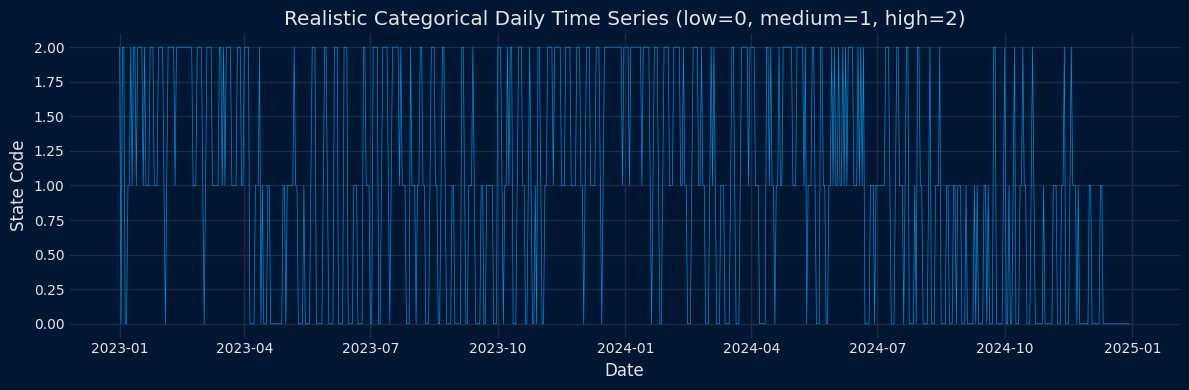

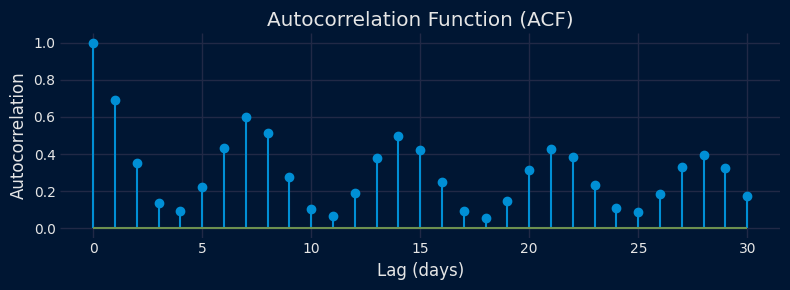

,state
date,
2023-01-01,high
2023-01-02,low
2023-01-03,high
2023-01-04,high
2023-01-05,low
...,...
2024-12-26,low
2024-12-27,low
2024-12-28,low


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Parameters
n_days = 365 * 2  # 2 years of daily data
seed = 42
rng = np.random.default_rng(seed)

# Define states
states = ["low", "medium", "high"]

# Latent AR process with memory at lags 1, 7, 14
phi1 = 0.6   # yesterday
phi7 = 0.25  # one week ago
phi14 = 0.1  # two weeks ago
noise_sd = 0.5

# Simulate latent continuous process
latent = np.zeros(n_days)
latent[:14] = rng.normal(0, 1, size=14)

for t in range(14, n_days):
    latent[t] = (
        phi1 * latent[t - 1]
        + phi7 * latent[t - 7]
        + phi14 * latent[t - 14]
        + rng.normal(0, noise_sd)
    )

# Add mild weekly seasonality (e.g., weekends slightly higher)
day_of_week = np.arange(n_days) % 7
latent += 0.5 * np.sin(2 * np.pi * day_of_week / 7)

# Discretize into 3 states using quantiles
q1, q2 = np.quantile(latent, [1/3, 2/3])
def to_state(x):
    if x < q1:
        return "low"
    elif x < q2:
        return "medium"
    else:
        return "high"

states_series = np.vectorize(to_state)(latent)

# Create DataFrame with daily frequency
dates = pd.date_range("2023-01-01", periods=n_days, freq="D")
df = pd.DataFrame({
    "date": dates,
    "state": states_series,
    "latent_value": latent
})

# Encode states numerically for analysis
state_map = {s: i for i, s in enumerate(states)}
df["state_code"] = df["state"].map(state_map)

# Save CSV
df.to_csv("realistic_categorical_daily_series.csv", index=False)

# --- Visualization ---
plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["state_code"], lw=0.5)
plt.title("Realistic Categorical Daily Time Series (low=0, medium=1, high=2)")
plt.xlabel("Date")
plt.ylabel("State Code")
plt.tight_layout()
plt.show()

# --- ACF Plot ---
acf_vals = acf(df["latent_value"], nlags=30, fft=True)
plt.figure(figsize=(8, 3))
plt.stem(range(len(acf_vals)), acf_vals)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

data = df[['date', 'state']].copy()
data = data.set_index('date')
data = data.asfreq('D')
data

In [28]:
# Data preprocessing
# ==============================================================================
# Encode categorical variable to plot
encode_map = {'low': 0, 'medium': 1, 'high': 2}
print(f"Encoding map: {encode_map}")
data['state_code'] = data['state'].map(encode_map)
data

Encoding map: {'low': 0, 'medium': 1, 'high': 2}


,state,state_code
date,,
2023-01-01,high,2
2023-01-02,low,0
2023-01-03,high,2
2023-01-04,high,2
2023-01-05,low,0
...,...,...
2024-12-26,low,0
2024-12-27,low,0
2024-12-28,low,0


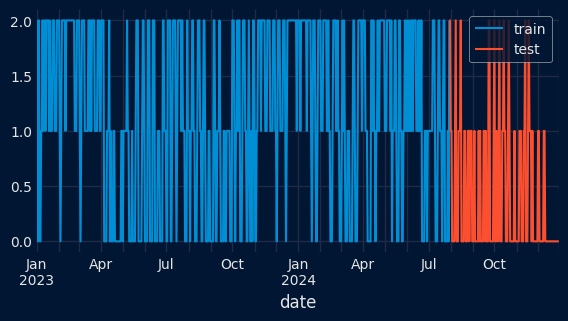

In [29]:
# Split train-test
# ==============================================================================
end_train = '2024-07-30'
data_train = data[:end_train]
data_test  = data[end_train:]

# Plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 3))
data_train['state_code'].plot(ax=ax, label='train')
data_test['state_code'].plot(ax=ax, label='test')
ax.legend();

## Create and train forecaster

In [31]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursiveClassifier(
                 regressor         = LGBMClassifier(random_state=123, verbose=-1),
                 lags              = 14,
                 window_features   = RollingFeaturesClassification(stats=['proportion'], window_sizes=21),
                 features_encoding = 'auto', 
             )

forecaster.fit(y=data_train['state'])
forecaster

============================= 
ForecasterRecursiveClassifier 
============================= 
Classifier: LGBMClassifier 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Window features: ['roll_proportion_21'] 
Window size: 21 
Series name: state 
Classes: ['high', 'low', 'medium'] 
Number of classes: 3 
Exogenous included: False 
Exogenous names: None 
Feature encoding: auto 
Transformer for exog: None 
Weight function included: False 
Training range: [Timestamp('2023-01-01 00:00:00'), Timestamp('2024-07-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Classifier parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-10-31 16:48:37 
Last fit date: 2025-10-31 16:48:37 
Skforecast version: 0.19.0 
Python version: 3.13.9 
Forecaster id: None

## Prediction

In [32]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps=7)
predictions.head(3)

2024-07-31      high
2024-08-01      high
2024-08-02    medium
Freq: D, Name: pred, dtype: object

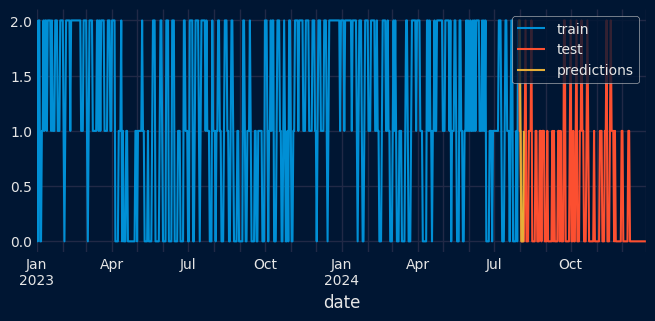

In [35]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['state_code'].plot(ax=ax, label='train')
data_test['state_code'].plot(ax=ax, label='test')
predictions = predictions.to_frame().assign(state_code=predictions.map(encode_map))
predictions['state_code'].plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.006632513357651682


## Predict probabilities

The method `predict_proba` allows to obtain the predicted probabilities for each category at each forecasted time step. It is important to note that these probabilities are the result of calling the `predict_proba` method of the underlying classifier, therefore, its calibration and reliability depend on the specific model used.

In [37]:
# Predict probabilities
# ==============================================================================
predictions = forecaster.predict_proba(steps=7)
predictions.head(3)

,high_proba,low_proba,medium_proba
2024-07-31,0.730424,0.044983,0.224593
2024-08-01,0.862387,0.066833,0.070781
2024-08-02,0.264689,0.034328,0.700983


## Feature importances

In [38]:
forecaster.get_feature_importances()

,feature,importance
14,roll_proportion_21_class_0,615
15,roll_proportion_21_class_1,569
16,roll_proportion_21_class_2,500
0,lag_1,434
7,lag_8,403
5,lag_6,351
6,lag_7,340
2,lag_3,338
3,lag_4,315
11,lag_12,314


## Training and prediction matrices

While the primary goal of building forecasting models is to predict future values, it is equally important to evaluate if the model is effectively learning from the training data. Analyzing predictions on the training data or exploring the prediction matrices is crucial for assessing model performance and understanding areas for optimization. This process can help identify issues like overfitting or underfitting, as well as provide deeper insights into the model’s decision-making process. Check the [How to Extract Training and Prediction Matrices](../user_guides/training-and-prediction-matrices.html) user guide for more information.